In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml

# autoreload modules
%load_ext autoreload
%autoreload 2



In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


In [3]:
# run_config_name = sys.argv[1]
# run_config_name = 'run_test_128_condFPM_uniformcic_fof_lgMmin5e13_wL2norm_highknots.yaml'
# run_config_name = 'run_Ntot_M1_Mdiff_128_condFPM_uniformcic_fof_lgMmin1e13_wL2norm_highknots.yaml'
# run_config_name = 'LONGTRAIN_BARR_run_Ntot_M1_Mdiff_256_condFPMFOF_cic_200c_lgMmin7e12_Nmax5_nc4_nsub512.yaml'
# run_config_name = 'LONGTRAIN_BARR_run_Ntot_M1_Mdiff_256_condFPMFOF_cic_200c_lgMmin7e12_Nmax5_nc4.yaml'
# run_config_name = 'LONGTRAIN_BARR_run_Ntot_M1_Mdiff_256_condFPM_cic_200c_lgMmin1e13_Nmax5_nc4_hdim6.yaml'
run_config_name = 'LONGTRAIN_BARR_run_Ntot_M1_Mdiff_256_condFPM_cic_200c_lgMmin1e13_Nmax5_nc4_hdim5_ns512.yaml'

with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)






In [4]:
config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']
ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
subsel_highM1 = config_sims['subsel_highM1']
nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
K_M1 = config_net['K_M1']
B_M1 = config_net['B_M1']
nflows_M1_NSF = config_net['nflows_M1_NSF']

K_Mdiff = config_net['K_Mdiff']
B_Mdiff = config_net['B_Mdiff']
nflows_Mdiff_NSF = config_net['nflows_Mdiff_NSF']

base_dist_Ntot = config_net['base_dist_Ntot']
if base_dist_Ntot == 'None':
    base_dist_Ntot = None
base_dist_M1 = config_net['base_dist_M1']
base_dist_Mdiff = config_net['base_dist_Mdiff']
ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    ninp = len(z_all_FP)
elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp


df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, ind_subsel_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_highM1=subsel_highM1, nsubsel=nsubsel, is_HR = is_HR
    )

# # Prepare the density and halo data
return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
    )

if cond_sim == 'fastpm':
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, ind_subsel_train_FP = load_density_halo_data_NGP(
        ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm', subsel_highM1=subsel_highM1, ind_subsel=ind_subsel_train
        )

    # # Prepare the density and halo data
    return_dict_train_FP = prep_density_halo_cats_batched(
        df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
        nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
        )
else:
    return_dict_train_FP = None

    


In [10]:
print(hidden_dim_MAF)



5


In [11]:
# is_HR
# stype



In [7]:
# df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, ind_subsel_train = load_density_halo_data_NGP(
#     ji_array, ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
#     stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_highM1=subsel_highM1, nsubsel=nsubsel, is_HR = is_HR
#     )

# # # Prepare the density and halo data
# return_dict_train = prep_density_halo_cats_batched(
#     df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, nsims=nsims_per_batch,
#     nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
#     )

# if cond_sim == 'fastpm':
#     df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, ind_subsel_train_FP = load_density_halo_data_NGP(
#         ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h, stype=stype,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm', subsel_highM1=subsel_highM1, ind_subsel=ind_subsel_train
#         )

#     # # Prepare the density and halo data
#     return_dict_train_FP = prep_density_halo_cats_batched(
#         df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, nsims=nsims_per_batch,
#         nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
#         )
# else:
#     return_dict_train_FP = None

    

In [8]:
# len(ind_subsel_train_FP), len(ind_subsel_train)
return_dict_train.keys()
# df_d_all_train.shape
# ji_array




dict_keys(['df_d_all', 'df_d_all_nsh', 'M_halos_all_sort_norm', 'Mmin', 'Mmax', 'Nmax', 'mask_M_diff', 'mask_M1', 'M1_halos_all_norm', 'M_diff_halos_all_norm_masked', 'Nhalo_train_mg_arr', 'N_halos_all', 'mu_all', 'sig_all', 'ngauss_Nhalo'])

In [9]:
# return_dict_train['df_d_all'].shape, return_dict_train_FP['df_d_all'].shape
# return_dict_train['M_halos_all_sort_norm'].shape, return_dict_train_FP['M_halos_all_sort_norm'].shape
# return_dict_train['M_diff_halos_all_norm_masked'].shape
return_dict_train['df_d_all_nsh'][0,:,0,...].shape, return_dict_train['N_halos_all'][0,...].shape


((512, 32, 32, 32), (512, 32768))

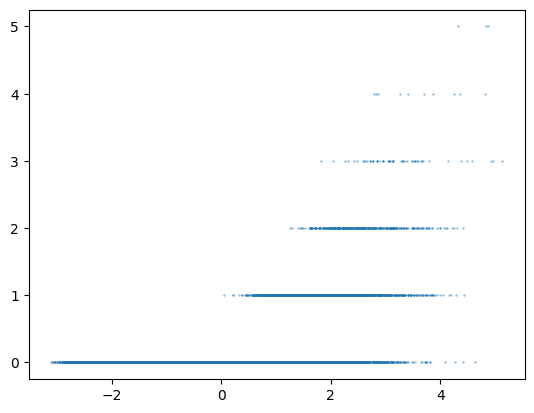

In [9]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['N_halos_all'][0,...].flatten()[::100], s=0.1)




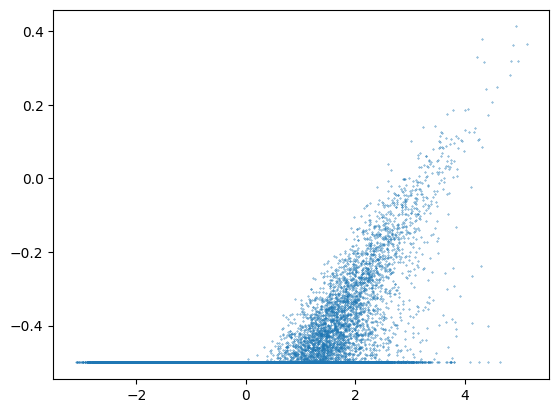

In [10]:
pl.figure()
_ = pl.scatter(return_dict_train['df_d_all_nsh'][0,:,0,...].flatten()[::100], return_dict_train['M1_halos_all_norm'][0,...].flatten()[::100], s=0.1)



In [ ]:
delta_all = return_dict_train['df_d_all_nsh'][0,:,0,...].reshape(148, 32768)
indsel = np.where(delta_all > 2.5)
pl.figure()
_ = pl.hist(return_dict_train_FP['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='FP')
_ = pl.hist(return_dict_train['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='PM')
pl.yscale('log')



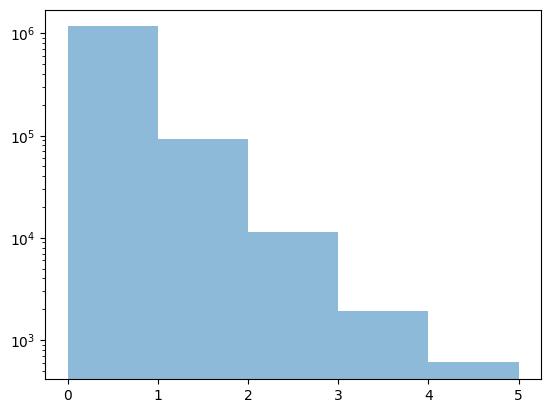

In [17]:
# lgMmin
# return_dict_train_FP['M1_halos_all_norm']
delta_all = return_dict_train['df_d_all_nsh'][0,:,0,...].reshape(148, 32768)
indsel = np.where(delta_all > 0.0)
pl.figure()
_ = pl.hist(return_dict_train['N_halos_all'][0,...][indsel].flatten(), bins=5, alpha=0.5, label='FP')
# _ = pl.hist(return_dict_train['M1_halos_all_norm'][0,...][indsel].flatten(), bins=100, alpha=0.5, label='PM')
pl.yscale('log')


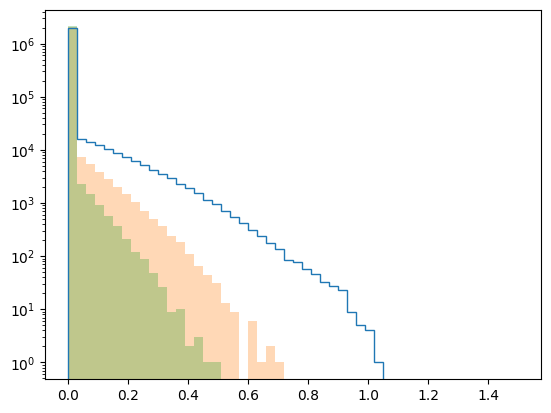

In [ ]:
pl.figure()
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,0].flatten(), bins=50, range=(0,1.5), histtype='step', label='z=0')
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,1].flatten(), bins=50, range=(0,1.5), alpha=0.3)
_ = pl.hist(return_dict_train['M_diff_halos_all_norm_masked'][...,2].flatten(), bins=50, range=(0,1.5), alpha=0.3)
pl.yscale('log')


In [13]:
return_dict_train['df_d_all'].shape

(1, 148, 4, 40, 40, 40)

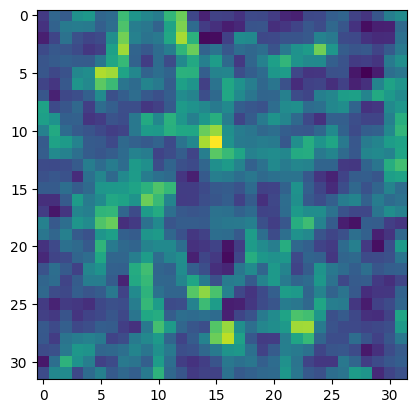

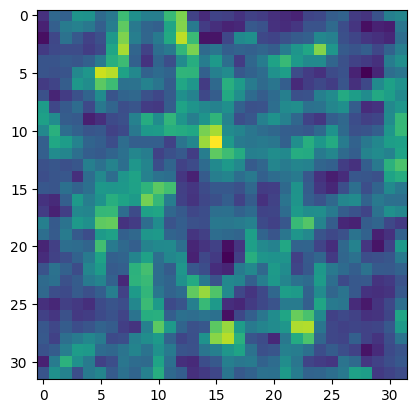

In [14]:
indp = 109

pl.figure()
pl.imshow(return_dict_train['df_d_all_nsh'][0,indp, 0, 8, :, :])
pl.figure()
pl.imshow(return_dict_train_FP['df_d_all_nsh'][0,indp, 0, 8, :, :])



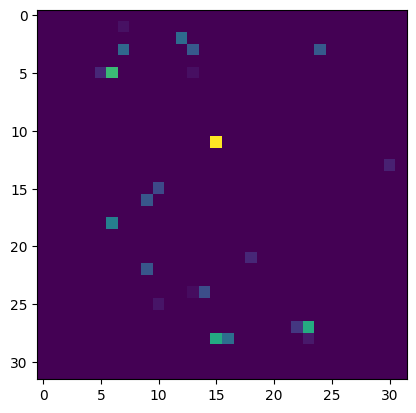

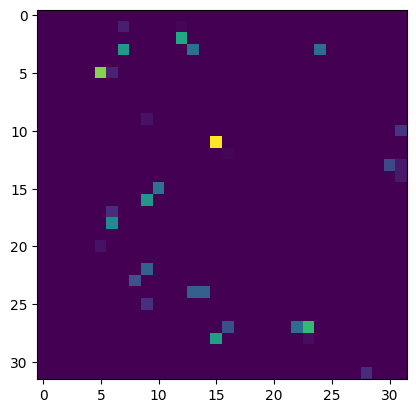

In [15]:
# indp = 10
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
pl.figure()
pl.imshow(return_dict_train['M_halos_all_sort_norm'][0,indp,:, 0].reshape(32,32,32)[8,:,:])
pl.figure()
pl.imshow(return_dict_train_FP['M_halos_all_sort_norm'][0,indp,:,0].reshape(32,32,32)[8,:,:])



In [12]:
lgM_array = np.linspace(lgMmin, lgMmax, 1000)
M_array = 10**lgM_array
if '200c' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = '200c', model = 'tinker08', q_out = 'dndlnM')
if 'vir' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'vir', model = 'tinker08', q_out = 'dndlnM')    
if 'fof' in mass_type:
    hmf = mass_function.massFunction(M_array, 0, mdef = 'fof', model = 'bhattacharya11', q_out = 'dndlnM')
lgM_rescaled = rescale_sub + (lgM_array - lgMmin)/(lgMmax-lgMmin)

int_val = sp.integrate.simps(hmf, lgM_rescaled)
hmf_pdf = hmf/int_val
# define the cdf of the halo mass function
hmf_cdf = np.zeros_like(hmf_pdf)
for i in range(len(hmf_cdf)):
    hmf_cdf[i] = sp.integrate.simps(hmf_pdf[:i+1], lgM_rescaled[:i+1])


# num_cond_Ntot = num_cond
# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()


In [13]:
# base_dist_Ntot


In [14]:
# from torch.utils.data import DataLoader, Dataset
# class LoadCustomData(Dataset):
#     def __init__(self, return_dict, return_dict_FP, all_gpu=False):
#         if return_dict_FP is not None:
#             self.cond_tensor = torch.Tensor(np.array(return_dict_FP['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict_FP['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
#         else:
#             self.cond_tensor = torch.Tensor(np.array(return_dict['df_d_all']))
#             cond_nsh = np.moveaxis(np.array(return_dict['df_d_all_nsh']), 2, 5)
#             self.cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

#         self.mask_tensor_M1_train = torch.Tensor(np.array(return_dict['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#         self.mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

#         self.X_M1 = torch.Tensor((np.array(return_dict['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Nhalo = torch.Tensor(np.array(return_dict['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         self.X_Mdiff = torch.Tensor(np.array(return_dict['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
#         self.Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

#         if return_dict_FP is not None:
#             self.mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
#             self.X_M1_FP = torch.Tensor((np.array(return_dict_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
#         else:
#             self.mask_tensor_M1_train_FP = None
#             self.X_M1_FP = None
#         if all_gpu:
#             self.cond_tensor = self.cond_tensor.cuda(dev)
#             self.cond_tensor_nsh = self.cond_tensor_nsh.cuda(dev)
#             self.mask_tensor_M1_train = self.mask_tensor_M1_train.cuda(dev)
#             self.mask_tensor_Mdiff_train = self.mask_tensor_Mdiff_train.cuda(dev)
#             self.X_M1 = self.X_M1.cuda(dev)
#             self.X_Nhalo = self.X_Nhalo.cuda(dev)
#             self.X_Mdiff = self.X_Mdiff.cuda(dev)
#             self.Nhalos_truth_tensor = self.Nhalos_truth_tensor.cuda(dev)
#             if return_dict_FP is not None:
#                 self.mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP.cuda(dev)
#                 self.X_M1_FP = self.X_M1_FP.cuda(dev)

#     def __len__(self):
#         return len(self.cond_tensor)

#     def __getitem__(self, idx):
#         cond_tensor = (self.cond_tensor[idx,...])
#         cond_tensor_nsh = self.cond_tensor_nsh[idx,...]
#         mask_tensor_M1_train = self.mask_tensor_M1_train[idx,...]
#         mask_tensor_Mdiff_train =self.mask_tensor_Mdiff_train[idx,...]
#         X_M1 = self.X_M1[idx,...]
#         X_Nhalo = self.X_Nhalo[idx,...]
#         X_Mdiff = self.X_Mdiff[idx,...]
#         Nhalos_truth_tensor = self.Nhalos_truth_tensor[idx,...]
#         if self.mask_tensor_M1_train_FP is not None:
#             mask_tensor_M1_train_FP = self.mask_tensor_M1_train_FP[idx,...]
#             X_M1_FP = self.X_M1_FP[idx,...]
#         else:
#             mask_tensor_M1_train_FP = torch.Tensor([-9999])
#             X_M1_FP = torch.Tensor([-9999])

#         return (cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, X_Nhalo,
#                  X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP)


# from torch.utils.data import DataLoader, Dataset


ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

mask_tensor_M1_train = torch.Tensor(np.array(return_dict_train['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
mask_tensor_Mdiff_train = torch.Tensor((np.array(return_dict_train['mask_M_diff']))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_diff)

X_M1 = torch.Tensor((np.array(return_dict_train['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Nhalo = torch.Tensor(np.array(return_dict_train['Nhalo_train_mg_arr'])).reshape(-1, nsims_per_batch * (nax_h**3), 1)
X_Mdiff = torch.Tensor(np.array(return_dict_train['M_diff_halos_all_norm_masked'])).reshape(-1, nsims_per_batch * (nax_h**3),ndim_diff)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)

if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = torch.Tensor(np.array(return_dict_train_FP['mask_M1'])).reshape(-1, nsims_per_batch * (nax_h**3))
    X_M1_FP = torch.Tensor((np.array(return_dict_train_FP['M1_halos_all_norm']))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
else:
    mask_tensor_M1_train_FP = None
    X_M1_FP = None

    
cond_tensor = cond_tensor.cuda(dev)
cond_tensor_nsh = cond_tensor_nsh.cuda(dev)
mask_tensor_M1_train = mask_tensor_M1_train.cuda(dev)
mask_tensor_Mdiff_train = mask_tensor_Mdiff_train.cuda(dev)
X_M1 = X_M1.cuda(dev)
X_Nhalo = X_Nhalo.cuda(dev)
X_Mdiff = X_Mdiff.cuda(dev)


Nhalos_truth_tensor = Nhalos_truth_tensor.cuda(dev)
if return_dict_train_FP is not None:
    mask_tensor_M1_train_FP = mask_tensor_M1_train_FP.cuda(dev)
    X_M1_FP = X_M1_FP.cuda(dev)




In [15]:
torch.amin(Nhalos_truth_tensor), torch.amax(Nhalos_truth_tensor), return_dict_train['mu_all']


(tensor(0., device='cuda:0'),
 tensor(5., device='cuda:0'),
 array([1, 2, 3, 4, 5, 6]))

In [9]:
# # X_Nhalo.shape, cond_tensor_nsh.shape
# np.array(return_dict_train['N_halos_all']).shape, cond_nsh.shape, np.array(return_dict_train['M1_halos_all_norm']).shape

# Nhalos_3d = np.array(return_dict_train['N_halos_all']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# Mhalos_3d = np.array(return_dict_train['M1_halos_all_norm']).reshape(-1, nsims_per_batch, nax_h, nax_h, nax_h)
# delta_m_3d = cond_nsh[...,0]




In [16]:
# # make a three panel plot
# import matplotlib.pyplot as pl
# import matplotlib
# %matplotlib inline
# indsim = 300
# pl.figure()
# pl.subplot(131)
# pl.imshow(Nhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(132)
# pl.imshow(Mhalos_3d[0,indsim,0,...])
# # pl.colorbar()
# pl.subplot(133)
# pl.imshow(delta_m_3d[0,indsim,0,...])
# # pl.colorbar()


In [17]:

# delta_m = cond_tensor_nsh[0,:,0].cpu().numpy()
# Nhalo = X_Nhalo[0,:,0].cpu().numpy()
# indsel = np.where((delta_m > 3) & (delta_m < 100))[0]
# pl.figure()
# pl.scatter(delta_m[indsel], Nhalo[indsel], s=0.1)


In [18]:
# np.amin(delta_m), np.amax(delta_m), np.amin(Nhalo), np.amax(Nhalo)



In [16]:
with open("/mnt/home/spandey/ceph/AR_NPE/run_configs/" + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)

config_train = config['train_settings']
batch_size = config_train['batch_size_DL']
all_gpu = config_train['all_gpu']

try:
    L2norm_Ntothist = config_train['L2norm_Ntothist']
except:
    L2norm_Ntothist = False

try:
    L2norm_M1hist = config_train['L2norm_M1hist']
except:
    L2norm_M1hist = False

nflows_train = config_train['nflows_train']

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/CLIPPED_FINALTEST_SUBSEL_Ntot_M1_Mdiff_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_TRY2'

save_string = config_train['save_string']

save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/LONGTRAIN_BARR_4Mpc_CLIPPED_FINALTEST_SUBSEL_Ntot_only_plexp_ns_' + str(len(ji_array)) + \
                            '_cond_sim_' + cond_sim  + '_ns_' + str(ns_h) \
                            + '_nc' + str(nc) + '_mass_' + mass_type + \
                            '_KM1_' + str(K_M1) + \
                            '_stype_' + stype + \
                            '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist) + '_Nmax' + str(Nmax) + save_string


print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# make directory if it doesn't exist
import os
if not os.path.exists(save_bestfit_model_dir):
    os.makedirs(save_bestfit_model_dir)


nepochs_Ntot_only = config_train['nepochs_Ntot_only']
nepochs_Ntot_M1_only = config_train['nepochs_Ntot_M1_only']
nepochs_all = config_train['nepochs_all']



# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST_SUBSEL_TEST_FINALS_SIMPLE_BATCHED_model_save_nsim' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim + \
#                             '_nsd' + str(ns_d) + '_nc' + str(nc) + '_nsh' + str(ns_h) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + '_nsimperbatch' + str(nsims_per_batch) + '_nbatches' + str(nbatches_train) + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_SUBSEL_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# save_bestfit_model_dir = '/mnt/home/spandey/ceph/AR_NPE/' + 'TRAIN_ROCKSTAR_FOF/FINALTEST2_NOSUBSEL_plexp_ns_' + str(len(ji_array)) + \
#                             '_cond_sim_' + cond_sim  \
#                             + '_nc' + str(nc) + '_mass_' + mass_type + \
#                             '_KM1_' + str(K_M1) + \
#                             '_stype_' + stype + \
#                             '_L2normNtothist_' + str(L2norm_Ntothist) + '_L2normM1hist_' + str(L2norm_M1hist)

# print(save_bestfit_model_dir, os.path.exists(save_bestfit_model_dir))
# # make directory if it doesn't exist
# import os
# if not os.path.exists(save_bestfit_model_dir):
#     os.makedirs(save_bestfit_model_dir)

# start_with_bestfit = config_train['start_with_bestfit']

# if start_with_bestfit:
#     try:
#         print('loading bestfit model')
#         bestfit_model = (torch.load(save_bestfit_model_name))
#         model.load_state_dict(bestfit_model['state_dict'])
#         optimizer.load_state_dict(bestfit_model['optimizer'])
#         scheduler.load_state_dict(bestfit_model['scheduler'])
#         loss_min = bestfit_model['loss_min']
#         loss = bestfit_model['loss']
#         lr = bestfit_model['lr']
#         epoch_tot_counter = bestfit_model['epoch_tot_counter']
#         for g in optimizer.param_groups:
#             # g['lr'] = lr
#             g['lr'] = 0.01          

#     except:
#         print('no bestfit model found, running new')
#         pass
#         epoch_tot_counter = 0


# dataset = LoadCustomData(return_dict_train, return_dict_train_FP, all_gpu=all_gpu)
# dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=1 - all_gpu, num_workers=1)




/mnt/home/spandey/ceph/AR_NPE/TRAIN_ROCKSTAR_FOF/LONGTRAIN_BARR_4Mpc_CLIPPED_FINALTEST_SUBSEL_Ntot_only_plexp_ns_4_cond_sim_fastpm_ns_256_nc4_mass_rockstar_200c_KM1_8_stype_cic_L2normNtothist_False_L2normM1hist_False_Nmax5_COND_FPM_Mmin1e13_hdim5_nf5_ns512 True


In [17]:
num_cond_Ntot = num_cond

model_Ntot = SumGaussModel(
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Ntot,
    ngauss=return_dict_train['ngauss_Nhalo'],
    mu_all=return_dict_train['mu_all'],
    sig_all=return_dict_train['sig_all'],
    base_dist=base_dist_Ntot   
    )

num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
if cond_sim == 'fastpm':
    num_cond_M1 += 2

model_M1 = NSF_M1_CNNcond(
    K=K_M1,
    B=B_M1,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_M1,
    nflows=nflows_M1_NSF,
    base_dist=base_dist_M1,
    ngauss=ngauss_M1,
    lgM_rs_tointerp=lgM_rescaled,
    hmf_pdf_tointerp=hmf_pdf,
    hmf_cdf_tointerp=hmf_cdf    
    )

ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'].shape[-1]
num_cond_Mdiff = num_cond + 2
model_Mdiff = NSF_Mdiff_CNNcond(
    dim=ndim_diff,
    K=K_Mdiff,
    B=B_Mdiff,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_Mdiff,
    nflows=nflows_Mdiff_NSF,
    base_dist=base_dist_Mdiff,
    mu_pos=True
    )

# model_Mdiff = None
# model_M1 = None

ndim = ndim_diff + 1
model = COMBINED_Model(
    None,
    model_Mdiff,
    # None,
    model_M1,
    model_Ntot,
    ndim,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    sep_Ntot_cond=True,
    sep_M1_cond=True,
    sep_Mdiff_cond=True,
    num_cond_Ntot = num_cond_Ntot,
    num_cond_M1 = num_cond_M1,
    num_cond_Mdiff = num_cond_Mdiff
    )

model.to(dev)
print()


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss_all_it = []
loss_min = 1e20
epoch_tot_counter = 0
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-5)






In [18]:
jf = 0
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

print('loading bestfit model')
bestfit_model = (torch.load(save_bestfit_model_name))
model.load_state_dict(bestfit_model['state_dict'])
optimizer.load_state_dict(bestfit_model['optimizer'])
scheduler.load_state_dict(bestfit_model['scheduler'])
loss_min = bestfit_model['loss_min']
loss = bestfit_model['loss']
lr = bestfit_model['lr']
epoch_tot_counter = bestfit_model['epoch_tot_counter']
for g in optimizer.param_groups:
    g['lr'] = lr
    # g['lr'] = 0.0005

print(loss_min, epoch_tot_counter, lr)






loading bestfit model
-1.5385456085205078 8515 0.001


In [16]:
jf = 0
save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

# train_Ntot_all = [1,1,1]
# train_M1_all = [0,1,1]
# train_Mdiff_all = [0,0,1]
# nepochs_all = [10000,4000,20000]


train_Ntot_all = [1]
train_M1_all = [0]
train_Mdiff_all = [0]
nepochs_all = [20000]

# if jn > 0:
#     print('loading bestfit model')
#     bestfit_model = (torch.load(save_bestfit_model_name))
#     model.load_state_dict(bestfit_model['state_dict'])
#     optimizer.load_state_dict(bestfit_model['optimizer'])
#     scheduler.load_state_dict(bestfit_model['scheduler'])
#     # loss_min = bestfit_model['loss_min']
#     loss = bestfit_model['loss']
#     lr = bestfit_model['lr']
#     for g in optimizer.param_groups:
#         g['lr'] = learning_rate
for js in range(len(train_Ntot_all)):
    train_Ntot = train_Ntot_all[js]
    train_M1 = train_M1_all[js]
    train_Mdiff = train_Mdiff_all[js]
    nepochs = nepochs_all[js]
    for jt in tqdm(range(nepochs)):
        # for jd in range(len(dataloader)):
        torch.cuda.empty_cache()
        optimizer.zero_grad()
        cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
            X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
                    X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

        if cond_sim == 'quijote':               
            mask_tensor_M1_train_FP_jd = None
            X_M1_FP_jd = None
        
        torch.cuda.empty_cache()
        # if 1-all_gpu:
        # cond_tensor_jd = cond_tensor_jd.cuda(dev)
        # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
        # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
        # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
        # X_M1_jd = X_M1_jd.cuda(dev)
        # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
        # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
        # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
        # if mask_tensor_M1_train_FP_jd is not None:
        #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
        #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
        # torch.cuda.empty_cache()
                        
        loss = model(
            X_Mdiff_jd,
            X_M1_jd,
            X_Nhalo_jd,
            cond_x=cond_tensor_jd,
            cond_x_nsh=cond_tensor_nsh_jd,
            mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
            mask_M1_truth_all=mask_tensor_M1_train_jd,
            Nhalos_truth_all=Nhalos_truth_tensor_jd,
            use_Ntot_samples=False,
            use_M1_samples=False,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            # x_Mdiff_FP=X_Mdiff_FP,
            x_M1_FP=X_M1_FP_jd,
            # x_Ntot_FP=X_Nhalo_FP,
            # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
            # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
            mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
            L2norm_Ntothist=L2norm_Ntothist,
            L2norm_M1hist=L2norm_M1hist        
            )

        loss.backward()
        optimizer.step()
        scheduler.step(loss) 
        epoch_tot_counter += 1
        if (np.mod(jt, int(nepochs / 300)) == 0) or (jt == nepochs - 1):
            if float(loss.cpu().detach().numpy()) < loss_min:
                loss_min = float(loss.cpu().detach().numpy())
                print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
                    'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
                    'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
                lr=optimizer.param_groups[0]['lr']
                # print(loss_min, lr)
                state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                        'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

                torch.save(
                    state, save_bestfit_model_name
                    )









  0%|          | 1/20000 [00:02<13:07:12,  2.36s/it]

saving bf at: , with loss: -1.40831 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1


  0%|          | 67/20000 [00:58<4:36:04,  1.20it/s]

saving bf at: , with loss: -1.50436 , at epoch: 66 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 67


  1%|          | 133/20000 [01:53<4:34:51,  1.20it/s]

saving bf at: , with loss: -1.52108 , at epoch: 132 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 133


  1%|          | 199/20000 [02:48<4:35:00,  1.20it/s]

saving bf at: , with loss: -1.52591 , at epoch: 198 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 199


  1%|▏         | 265/20000 [03:43<4:35:35,  1.19it/s]

saving bf at: , with loss: -1.5283 , at epoch: 264 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 265


  2%|▏         | 331/20000 [04:38<4:52:19,  1.12it/s]

saving bf at: , with loss: -1.52987 , at epoch: 330 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 331


  2%|▏         | 397/20000 [05:32<4:30:54,  1.21it/s]

saving bf at: , with loss: -1.531 , at epoch: 396 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 397


  2%|▏         | 463/20000 [06:28<4:32:39,  1.19it/s]

saving bf at: , with loss: -1.53179 , at epoch: 462 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 463


  3%|▎         | 595/20000 [08:18<4:29:07,  1.20it/s]

saving bf at: , with loss: -1.5329 , at epoch: 594 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 595


  3%|▎         | 661/20000 [09:13<4:29:16,  1.20it/s]

saving bf at: , with loss: -1.53327 , at epoch: 660 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 661


  4%|▎         | 727/20000 [10:08<4:42:10,  1.14it/s]

saving bf at: , with loss: -1.53352 , at epoch: 726 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 727


  4%|▍         | 793/20000 [11:03<4:25:33,  1.21it/s]

saving bf at: , with loss: -1.53377 , at epoch: 792 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 793


  4%|▍         | 859/20000 [11:57<4:24:34,  1.21it/s]

saving bf at: , with loss: -1.53416 , at epoch: 858 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 859


  5%|▍         | 991/20000 [13:48<4:23:41,  1.20it/s]

saving bf at: , with loss: -1.53452 , at epoch: 990 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 991


  5%|▌         | 1057/20000 [14:43<4:24:56,  1.19it/s]

saving bf at: , with loss: -1.53466 , at epoch: 1056 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1057


  6%|▌         | 1123/20000 [15:39<4:30:03,  1.17it/s]

saving bf at: , with loss: -1.53489 , at epoch: 1122 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1123


  6%|▌         | 1189/20000 [16:33<4:20:53,  1.20it/s]

saving bf at: , with loss: -1.53497 , at epoch: 1188 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1189


  6%|▋         | 1255/20000 [17:28<4:20:00,  1.20it/s]

saving bf at: , with loss: -1.53512 , at epoch: 1254 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1255


  7%|▋         | 1321/20000 [18:24<4:20:06,  1.20it/s]

saving bf at: , with loss: -1.53523 , at epoch: 1320 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1321


  7%|▋         | 1387/20000 [19:19<4:18:22,  1.20it/s]

saving bf at: , with loss: -1.53527 , at epoch: 1386 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1387


  7%|▋         | 1453/20000 [20:14<4:19:00,  1.19it/s]

saving bf at: , with loss: -1.53538 , at epoch: 1452 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1453


  8%|▊         | 1519/20000 [21:09<4:20:14,  1.18it/s]

saving bf at: , with loss: -1.5355 , at epoch: 1518 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1519


  8%|▊         | 1651/20000 [22:59<4:15:36,  1.20it/s]

saving bf at: , with loss: -1.53553 , at epoch: 1650 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1651


  9%|▊         | 1717/20000 [23:55<4:13:27,  1.20it/s]

saving bf at: , with loss: -1.53574 , at epoch: 1716 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1717


  9%|▉         | 1783/20000 [24:50<4:14:08,  1.19it/s]

saving bf at: , with loss: -1.53583 , at epoch: 1782 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1783


 10%|▉         | 1915/20000 [26:42<4:15:40,  1.18it/s]

saving bf at: , with loss: -1.53587 , at epoch: 1914 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1915


 10%|▉         | 1981/20000 [27:37<4:23:36,  1.14it/s]

saving bf at: , with loss: -1.53593 , at epoch: 1980 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 1981


 10%|█         | 2047/20000 [28:32<4:09:27,  1.20it/s]

saving bf at: , with loss: -1.53615 , at epoch: 2046 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2047


 11%|█         | 2113/20000 [29:28<4:08:29,  1.20it/s]

saving bf at: , with loss: -1.53638 , at epoch: 2112 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2113


 11%|█         | 2245/20000 [31:19<4:07:06,  1.20it/s]

saving bf at: , with loss: -1.5365 , at epoch: 2244 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2245


 12%|█▏        | 2311/20000 [32:14<4:07:10,  1.19it/s]

saving bf at: , with loss: -1.53654 , at epoch: 2310 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2311


 12%|█▏        | 2377/20000 [33:09<4:09:42,  1.18it/s]

saving bf at: , with loss: -1.53675 , at epoch: 2376 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2377


 13%|█▎        | 2509/20000 [34:59<4:02:03,  1.20it/s]

saving bf at: , with loss: -1.53678 , at epoch: 2508 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2509


 13%|█▎        | 2575/20000 [35:55<4:02:02,  1.20it/s]

saving bf at: , with loss: -1.53685 , at epoch: 2574 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2575


 14%|█▎        | 2707/20000 [37:46<4:00:18,  1.20it/s]

saving bf at: , with loss: -1.53699 , at epoch: 2706 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2707


 15%|█▍        | 2905/20000 [40:32<3:56:48,  1.20it/s]

saving bf at: , with loss: -1.53701 , at epoch: 2904 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2905


 15%|█▍        | 2971/20000 [41:28<3:57:02,  1.20it/s]

saving bf at: , with loss: -1.53717 , at epoch: 2970 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 2971


 15%|█▌        | 3037/20000 [42:24<3:54:59,  1.20it/s]

saving bf at: , with loss: -1.53722 , at epoch: 3036 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3037


 16%|█▌        | 3169/20000 [44:14<3:53:58,  1.20it/s]

saving bf at: , with loss: -1.53727 , at epoch: 3168 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3169


 17%|█▋        | 3301/20000 [46:05<3:52:11,  1.20it/s]

saving bf at: , with loss: -1.53732 , at epoch: 3300 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3301


 17%|█▋        | 3367/20000 [47:00<3:50:53,  1.20it/s]

saving bf at: , with loss: -1.53739 , at epoch: 3366 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3367


 17%|█▋        | 3499/20000 [48:52<3:48:48,  1.20it/s]

saving bf at: , with loss: -1.53747 , at epoch: 3498 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3499


 19%|█▉        | 3829/20000 [53:29<3:45:16,  1.20it/s]

saving bf at: , with loss: -1.53761 , at epoch: 3828 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3829


 19%|█▉        | 3895/20000 [54:25<3:44:07,  1.20it/s]

saving bf at: , with loss: -1.53763 , at epoch: 3894 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3895


 20%|█▉        | 3961/20000 [55:21<3:42:53,  1.20it/s]

saving bf at: , with loss: -1.53765 , at epoch: 3960 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 3961


 21%|██▏       | 4291/20000 [59:59<3:37:54,  1.20it/s]

saving bf at: , with loss: -1.53766 , at epoch: 4290 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4291


 22%|██▏       | 4423/20000 [1:01:51<3:37:17,  1.19it/s]

saving bf at: , with loss: -1.53774 , at epoch: 4422 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4423


 23%|██▎       | 4621/20000 [1:04:38<3:49:28,  1.12it/s]

saving bf at: , with loss: -1.53786 , at epoch: 4620 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4621


 24%|██▍       | 4885/20000 [1:08:19<3:29:45,  1.20it/s]

saving bf at: , with loss: -1.53786 , at epoch: 4884 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4885


 25%|██▍       | 4951/20000 [1:09:14<3:30:33,  1.19it/s]

saving bf at: , with loss: -1.53794 , at epoch: 4950 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4951


 26%|██▌       | 5149/20000 [1:12:00<3:25:46,  1.20it/s]

saving bf at: , with loss: -1.53796 , at epoch: 5148 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5149


 26%|██▋       | 5281/20000 [1:13:51<3:29:54,  1.17it/s]

saving bf at: , with loss: -1.53799 , at epoch: 5280 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5281


 27%|██▋       | 5347/20000 [1:14:46<3:23:59,  1.20it/s]

saving bf at: , with loss: -1.53805 , at epoch: 5346 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5347


 28%|██▊       | 5545/20000 [1:17:31<3:21:07,  1.20it/s]

saving bf at: , with loss: -1.53808 , at epoch: 5544 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5545


 29%|██▊       | 5743/20000 [1:20:17<3:18:30,  1.20it/s]

saving bf at: , with loss: -1.53812 , at epoch: 5742 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5743


 29%|██▉       | 5809/20000 [1:21:13<3:18:17,  1.19it/s]

saving bf at: , with loss: -1.53814 , at epoch: 5808 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5809


 30%|██▉       | 5941/20000 [1:23:03<3:16:44,  1.19it/s]

saving bf at: , with loss: -1.53815 , at epoch: 5940 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 5941


 31%|███       | 6139/20000 [1:25:48<3:12:12,  1.20it/s]

saving bf at: , with loss: -1.53821 , at epoch: 6138 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6139


 31%|███▏      | 6271/20000 [1:27:39<3:17:14,  1.16it/s]

saving bf at: , with loss: -1.53824 , at epoch: 6270 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6271


 33%|███▎      | 6535/20000 [1:31:19<3:06:49,  1.20it/s]

saving bf at: , with loss: -1.53825 , at epoch: 6534 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6535


 33%|███▎      | 6667/20000 [1:33:09<3:10:47,  1.16it/s]

saving bf at: , with loss: -1.53829 , at epoch: 6666 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6667


 34%|███▍      | 6799/20000 [1:34:59<3:03:39,  1.20it/s]

saving bf at: , with loss: -1.53831 , at epoch: 6798 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6799


 35%|███▍      | 6931/20000 [1:36:49<3:01:35,  1.20it/s]

saving bf at: , with loss: -1.53834 , at epoch: 6930 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 6931


 35%|███▌      | 7063/20000 [1:38:40<3:08:45,  1.14it/s]

saving bf at: , with loss: -1.53836 , at epoch: 7062 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7063


 37%|███▋      | 7327/20000 [1:42:20<2:56:32,  1.20it/s]

saving bf at: , with loss: -1.53837 , at epoch: 7326 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7327


 38%|███▊      | 7525/20000 [1:45:06<3:05:44,  1.12it/s]

saving bf at: , with loss: -1.5384 , at epoch: 7524 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7525


 38%|███▊      | 7591/20000 [1:46:01<2:52:08,  1.20it/s]

saving bf at: , with loss: -1.5384 , at epoch: 7590 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7591


 39%|███▊      | 7723/20000 [1:47:52<2:50:29,  1.20it/s]

saving bf at: , with loss: -1.53843 , at epoch: 7722 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7723


 40%|███▉      | 7921/20000 [1:50:37<2:55:48,  1.15it/s]

saving bf at: , with loss: -1.53844 , at epoch: 7920 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 7921


 41%|████      | 8185/20000 [1:54:17<2:44:05,  1.20it/s]

saving bf at: , with loss: -1.53851 , at epoch: 8184 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8185


 42%|████▏     | 8449/20000 [1:57:58<2:40:47,  1.20it/s]

saving bf at: , with loss: -1.53851 , at epoch: 8448 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8449


 43%|████▎     | 8515/20000 [1:58:53<2:39:08,  1.20it/s]

saving bf at: , with loss: -1.53855 , at epoch: 8514 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 8515


 44%|████▍     | 8806/20000 [2:02:57<2:36:18,  1.19it/s]


KeyboardInterrupt: 

In [70]:
# # nepochs_array = 1000
# L2norm_Ntothist = True
# # for jn in (range(len(nepochs_array))):
# loss_min = 1e20
# torch.cuda.empty_cache()
# ninit = 0
# nepochs = 1000
# if nepochs > 0:
#     train_Ntot = train_Ntot_array[jn]
#     train_M1 = train_M1_array[jn]
#     train_Mdiff = train_Mdiff_array[jn]

#     # if jn > 0:
#     #     print('loading bestfit model')
#     #     bestfit_model = (torch.load(save_bestfit_model_name))
#     #     model.load_state_dict(bestfit_model['state_dict'])
#     #     optimizer.load_state_dict(bestfit_model['optimizer'])
#     #     scheduler.load_state_dict(bestfit_model['scheduler'])
#     #     # loss_min = bestfit_model['loss_min']
#     #     loss = bestfit_model['loss']
#     #     lr = bestfit_model['lr']
#     #     for g in optimizer.param_groups:
#     #         g['lr'] = learning_rate

#     for jt in (range(nepochs)):
#         # for jd in range(len(dataloader)):
#         torch.cuda.empty_cache()
#         optimizer.zero_grad()
#         cond_tensor_jd, cond_tensor_nsh_jd, mask_tensor_M1_train_jd, mask_tensor_Mdiff_train_jd, X_M1_jd, \
#             X_Nhalo_jd, X_Mdiff_jd, Nhalos_truth_tensor_jd, mask_tensor_M1_train_FP_jd, X_M1_FP_jd = cond_tensor, cond_tensor_nsh, mask_tensor_M1_train, mask_tensor_Mdiff_train, X_M1, \
#                     X_Nhalo, X_Mdiff, Nhalos_truth_tensor, mask_tensor_M1_train_FP, X_M1_FP

#         if cond_sim == 'quijote':               
#             mask_tensor_M1_train_FP_jd = None
#             X_M1_FP_jd = None
        
#         torch.cuda.empty_cache()
#         # if 1-all_gpu:
#         # cond_tensor_jd = cond_tensor_jd.cuda(dev)
#         # cond_tensor_nsh_jd = cond_tensor_nsh_jd.cuda(dev)
#         # mask_tensor_M1_train_jd = mask_tensor_M1_train_jd.cuda(dev)
#         # mask_tensor_Mdiff_train_jd = mask_tensor_Mdiff_train_jd.cuda(dev)
#         # X_M1_jd = X_M1_jd.cuda(dev)
#         # X_Nhalo_jd = X_Nhalo_jd.cuda(dev)
#         # X_Mdiff_jd = X_Mdiff_jd.cuda(dev)
#         # Nhalos_truth_tensor_jd = Nhalos_truth_tensor_jd.cuda(dev)
#         # if mask_tensor_M1_train_FP_jd is not None:
#         #     mask_tensor_M1_train_FP_jd = mask_tensor_M1_train_FP_jd.cuda(dev)
#         #     X_M1_FP_jd = X_M1_FP_jd.cuda(dev)
#         # torch.cuda.empty_cache()
                        
#         loss = model(
#             X_Mdiff_jd,
#             X_M1_jd,
#             X_Nhalo_jd,
#             cond_x=cond_tensor_jd,
#             cond_x_nsh=cond_tensor_nsh_jd,
#             mask_Mdiff_truth_all=mask_tensor_Mdiff_train_jd,
#             mask_M1_truth_all=mask_tensor_M1_train_jd,
#             Nhalos_truth_all=Nhalos_truth_tensor_jd,
#             use_Ntot_samples=False,
#             use_M1_samples=False,
#             train_Ntot=train_Ntot,
#             train_M1=train_M1,
#             train_Mdiff=train_Mdiff,
#             # x_Mdiff_FP=X_Mdiff_FP,
#             x_M1_FP=X_M1_FP_jd,
#             # x_Ntot_FP=X_Nhalo_FP,
#             # Nhalos_truth_all_FP=Nhalos_truth_tensor_FP,
#             # mask_Mdiff_truth_all_FP=mask_tensor_Mdiff_train_FP,
#             mask_M1_truth_all_FP=mask_tensor_M1_train_FP_jd,
#             L2norm_Ntothist=L2norm_Ntothist,
#             L2norm_M1hist=L2norm_M1hist        
#             )

#         loss.backward()
#         optimizer.step()
#         scheduler.step(loss)
#         epoch_tot_counter += 1
#         if (np.mod(jt, int(nepochs / 200)) == 0) or (jt == nepochs - 1):
#             if float(loss.cpu().detach().numpy()) < loss_min:
#                 loss_min = float(loss.cpu().detach().numpy())
#                 print('saving bf at:', ', with loss:', np.round(loss_min, 5), ', at epoch:', jt, 
#                     'learning rate:', optimizer.param_groups[0]['lr'], ', train_Ntot:', train_Ntot, 
#                     'train_M1:', train_M1, ', train_Mdiff:', train_Mdiff, ', epoch_tot_counter:', epoch_tot_counter)
#                 lr=optimizer.param_groups[0]['lr']
#                 # print(loss_min, lr)
#                 # state = {'loss_min': loss_min, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
#                 #         'scheduler': scheduler.state_dict(), 'loss':loss, 'lr':lr, 'epoch_tot_counter':epoch_tot_counter}

#                 # torch.save(
#                 #     state, save_bestfit_model_name
#                 #     )




saving bf at: , with loss: 1.75594 , at epoch: 0 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4001
saving bf at: , with loss: 1.0999 , at epoch: 5 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4006
saving bf at: , with loss: 0.67733 , at epoch: 35 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4036
saving bf at: , with loss: 0.42723 , at epoch: 70 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4071
saving bf at: , with loss: 0.24428 , at epoch: 95 learning rate: 0.001 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4096
Epoch 04101: reducing learning rate of group 0 to 2.5000e-04.
Epoch 04302: reducing learning rate of group 0 to 6.2500e-05.
saving bf at: , with loss: 0.20969 , at epoch: 405 learning rate: 6.25e-05 , train_Ntot: 1 train_M1: 0 , train_Mdiff: 0 , epoch_tot_counter: 4406
Epoch 04503: reducing l

In [17]:
# num_cond_Ntot = num_cond

# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# # ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# # num_cond_Mdiff = num_cond + 2
# # model_Mdiff = NSF_Mdiff_CNNcond(
# #     dim=ndim_diff,
# #     K=K_Mdiff,
# #     B=B_Mdiff,
# #     hidden_dim=hidden_dim_MAF,
# #     num_cond=num_cond_Mdiff,
# #     nflows=nflows_Mdiff_NSF,
# #     base_dist=base_dist_Mdiff,
# #     mu_pos=True
# #     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     None,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = None
#     )

# model.to(dev)
# print()


# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_all_it = []
# loss_min = 1e20
# epoch_tot_counter = 0
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.25, patience=100, verbose=True, cooldown=100, min_lr=1e-8)



In [49]:
# jf = 1
# save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)

# print('loading bestfit model')
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']
# lr = bestfit_model['lr']
# epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr

# print(loss_min, epoch_tot_counter, lr)




loading bestfit model
-1.0573930740356445 8201 1.52587890625e-08


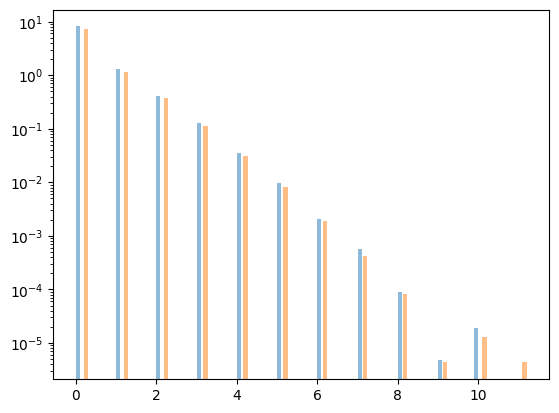

In [58]:
# # model_Ntot
# # base_dist_Ntot
# # 203968/1817977 
# cond_out = model.conv_layers(cond_tensor_jd[0])
# cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# # if self.sep_Ntot_cond:
# cond_out_Ntot = model.cond_Ntot_layer(cond_out)

# Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
# Ntot_samp = np.maximum(np.round(Ntot_samp_tensor.cpu().detach().numpy()) - 1, 0).astype(int)
# pl.figure()
# _ = pl.hist(Ntot_samp, bins=100, density=True, alpha=0.5)
# _ = pl.hist(0.2+Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# pl.yscale('log')



In [8]:
# # for jf in range(7):
# #     save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(jf)
# #     bestfit_model = (torch.load(save_bestfit_model_name))
# #     loss_min = bestfit_model['loss_min']
# #     print(loss_min)

# num_cond_Ntot = num_cond

# model_Ntot = SumGaussModel(
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Ntot,
#     ngauss=return_dict_train['ngauss_Nhalo'],
#     mu_all=return_dict_train['mu_all'],
#     sig_all=return_dict_train['sig_all'],
#     base_dist=base_dist_Ntot   
#     )

# num_cond_M1 = num_cond + 1
# # if conditioned on fastpm we will also give the fastpm fof M1 halos and its mask as conditional
# if cond_sim == 'fastpm':
#     num_cond_M1 += 2

# model_M1 = NSF_M1_CNNcond(
#     K=K_M1,
#     B=B_M1,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_M1,
#     nflows=nflows_M1_NSF,
#     base_dist=base_dist_M1,
#     ngauss=ngauss_M1,
#     lgM_rs_tointerp=lgM_rescaled,
#     hmf_pdf_tointerp=hmf_pdf,
#     hmf_cdf_tointerp=hmf_cdf    
#     )

# ndim_diff = return_dict_train['M_diff_halos_all_norm_masked'][0].shape[2]
# num_cond_Mdiff = num_cond + 2
# model_Mdiff = NSF_Mdiff_CNNcond(
#     dim=ndim_diff,
#     K=K_Mdiff,
#     B=B_Mdiff,
#     hidden_dim=hidden_dim_MAF,
#     num_cond=num_cond_Mdiff,
#     nflows=nflows_Mdiff_NSF,
#     base_dist=base_dist_Mdiff,
#     mu_pos=True
#     )

# ndim = ndim_diff + 1
# model = COMBINED_Model(
#     None,
#     model_Mdiff,
#     # None,
#     model_M1,
#     model_Ntot,
#     ndim,
#     ksize,
#     ns_d,
#     ns_h,
#     nb,
#     ninp,
#     nfeature_cnn,
#     nout_cnn,
#     layers_types=layers_types,
#     act='tanh',
#     padding='valid',
#     sep_Ntot_cond=True,
#     sep_M1_cond=True,
#     sep_Mdiff_cond=True,
#     num_cond_Ntot = num_cond_Ntot,
#     num_cond_M1 = num_cond_M1,
#     num_cond_Mdiff = num_cond_Mdiff
#     )

# model.to(dev)

# print()

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_all_it = []
# loss_min = 1e20
# epoch_tot_counter = 0
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=200, verbose=True, cooldown=200, min_lr=1e-8)

# save_bestfit_model_name = save_bestfit_model_dir + '/flow_' + str(0)
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# # loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']


In [9]:
print(loss)


tensor([-1.2101], device='cuda:0', requires_grad=True)


In [10]:
# print('loading bestfit model')
# bestfit_model = (torch.load(save_bestfit_model_name))
# model.load_state_dict(bestfit_model['state_dict'])
# optimizer.load_state_dict(bestfit_model['optimizer'])
# scheduler.load_state_dict(bestfit_model['scheduler'])
# loss_min = bestfit_model['loss_min']
# loss = bestfit_model['loss']
# lr = bestfit_model['lr']
# epoch_tot_counter = bestfit_model['epoch_tot_counter']
# for g in optimizer.param_groups:
#     g['lr'] = lr

# print(loss_min, epoch_tot_counter, lr)




In [19]:
import readfof
import numpy as np
import pickle as pk 
# from nbodykit.lab import *
import h5py as h5
import numpy as np
import Pk_library as PKL
import MAS_library as MASL
import yaml

print(loss_min, epoch_tot_counter, stype)

train_Ntot, train_M1, train_Mdiff = 1, 0, 0
# train_Ntot, train_M1, train_Mdiff = 1, 1, 0
# train_Ntot, train_M1, train_Mdiff = 1, 0, 0
isim_start = 0
isim_end = 1
isim_all = np.arange(isim_start, isim_end).astype(int)
for ji in range(len(isim_all)):
    saved_all_jsim = {}
    # now we load the test data
    isim = isim_all[ji]
    print('DOING SIM NUMBER:' + str(isim))
    nstart = 0
    nsims_test = 64
    df_d_all_test, df_d_all_nsh_test, df_Mh_all_test, df_Nh_test, _ = load_density_halo_data_NGP(
        [isim], ns_d, nb, nf, nc, z_all, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self',
        stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, is_HR=is_HR
        )

    if cond_sim == 'fastpm':
        df_d_all_test_FP, df_d_all_nsh_test_FP, df_Mh_all_test_FP, df_Nh_test_FP, _ = load_density_halo_data_NGP(
            [isim], ns_d, nb, nf, nc, z_all_FP, ns_h,sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',
            stype=stype
            )

    # things are too big to load all at once, so we load in batches
    nq = nb**3 // nsims_test
    save_subvol_Nhalo = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_Nhalo_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    cond_z0_truth = np.zeros((nb**3, nax_h, nax_h, nax_h))
    save_subvol_M1 = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_M1_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, 1))
    save_subvol_Mdiff = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    save_subvol_Mdiff_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff))
    mask_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    mask_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))

    # nfeatures_M1_tot = 20
    # cond_inp_M1_all = np.zeros((nb**3, nax_h, nax_h, nax_h, nfeatures_M1_tot))
    density_out_M1_loc_all_pad = np.zeros((nb**3, nax_h+6, nax_h+6, nax_h+6))
    density_out_M1_loc_all = np.zeros((nb**3, nax_h, nax_h, nax_h))

    nscount = 0
    for jq in range(nq):
        # Load the density data


        # Prepare the density and halo data
        return_dict_test = prep_density_halo_cats(
            df_d_all_test,
            df_d_all_nsh_test,
            df_Mh_all_test,
            df_Nh_test,
            nsims=nsims_test,
            nstart=nscount,
            Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax
            )
        
        if cond_sim == 'fastpm':
            return_dict_test_FP = prep_density_halo_cats(
                df_d_all_test_FP,
                df_d_all_nsh_test_FP,
                df_Mh_all_test_FP,
                df_Nh_test_FP,
                nsims=nsims_test,
                nstart=nscount,
                Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub
                )    

        if cond_sim == 'fastpm':
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test_FP['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test_FP['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)    
        else:
            cond_tensor_test = torch.Tensor(np.copy(np.array([return_dict_test['df_d_all']]))).cuda(dev)
            cond_nsh_test = np.moveaxis(return_dict_test['df_d_all_nsh'], 1, 4)
            cond_nsh_test = np.array([cond_nsh_test])
            cond_tensor_nsh_test = torch.Tensor(np.copy(cond_nsh_test.reshape(1,nsims_test * (nax_h ** 3), ninp))).cuda(dev)

        mask_tensor_M1_test = torch.Tensor(np.copy(return_dict_test['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
        mask_tensor_Mdiff_test = torch.Tensor(
            (return_dict_test['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            ).cuda(dev)

        X_M1_test = torch.Tensor((return_dict_test['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
        X_Nhalo_test = torch.Tensor(return_dict_test['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
        X_Mdiff_test = torch.Tensor(
            return_dict_test['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            ).cuda(dev)
        Nhalos_truth_tensor_test = torch.Tensor(((return_dict_test['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                        1)))).cuda(dev)
        
        if cond_sim == 'fastpm':
            mask_tensor_M1_test_FP = torch.Tensor(np.copy(return_dict_test_FP['mask_M1'].reshape(1,nsims_test * (nax_h**3)))).cuda(dev)
            # mask_tensor_Mdiff_test_FP = torch.Tensor(
            #     (return_dict_test_FP['mask_M_diff'].reshape(1,nsims_test * (nax_h**3), ndim_diff))
            #     ).cuda(dev)

            X_M1_test_FP = torch.Tensor((return_dict_test_FP['M1_halos_all_norm'].reshape(1,nsims_test * (nax_h**3), 1))).cuda(dev)
            X_Nhalo_test_FP = torch.Tensor(return_dict_test_FP['Nhalo_train_mg_arr'].reshape(1,nsims_test * (nax_h**3), 1)).cuda(dev)
            # X_Mdiff_test_FP = torch.Tensor(
            #     return_dict_test_FP['M_diff_halos_all_norm_masked'].reshape(1,nsims_test * (nax_h**3), ndim_diff)
            #     ).cuda(dev)
            Nhalos_truth_tensor_test_FP = torch.Tensor(((return_dict_test_FP['N_halos_all'].reshape(1,nsims_test * (nax_h**3),
                                                                                            1)))).cuda(dev)
        else:
            mask_tensor_M1_test_FP = None
            mask_tensor_Mdiff_test_FP = None
            X_M1_test_FP = None
            X_Nhalo_test_FP = None
            X_Mdiff_test_FP = None
            Nhalos_truth_tensor_test_FP = None

        Ntot_samp_test, M1_samp_test, M_diff_samp_test, mask_tensor_M1_samp_test, mask_tensor_Mdiff_samp_test, cond_inp_M1_test = model.inverse(
            cond_x=cond_tensor_test,
            cond_x_nsh=cond_tensor_nsh_test,
            use_truth_Nhalo=1-train_Ntot,
                use_truth_M1=1-train_M1,
                use_truth_Mdiff=1-train_Mdiff, 
            mask_Mdiff_truth=mask_tensor_Mdiff_test,
            mask_M1_truth=mask_tensor_M1_test,
            Nhalos_truth=X_Nhalo_test,
            M1_truth=X_M1_test,
            Mdiff_truth=X_Mdiff_test,
            train_Ntot=train_Ntot,
            train_M1=train_M1,
            train_Mdiff=train_Mdiff,
            x_M1_FP=X_M1_test_FP,   
            mask_M1_truth_all_FP=mask_tensor_M1_test_FP 
            )
        Ntot_samp_test = Ntot_samp_test[0][:,np.newaxis]
        # print(Ntot_samp_test.shape)
        save_subvol_Nhalo[nscount:nscount + nsims_test, ...] = Ntot_samp_test.reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_Nhalo_truth[nscount:nscount + nsims_test, ...] = Nhalos_truth_tensor_test.cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        save_subvol_M1[nscount:nscount + nsims_test,
                    ...] = (M1_samp_test[0] * mask_tensor_M1_samp_test[0][:,0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)
        save_subvol_M1_truth[nscount:nscount + nsims_test,
                    ...] = (X_M1_test[0][:,0] * mask_tensor_M1_test[0]
                            ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, 1)    
        # cond_inp_M1_all[nscount:nscount + nsims_test,
        #                ...] = cond_inp_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, nfeatures_M1_tot)
        # density_out_M1_loc_all_pad[nscount:nscount + nsims_test,...] = (cond_tensor_test[0,:,0,...].cpu().detach().numpy())
        # density_out_M1_loc_all[nscount:nscount + nsims_test,...] = (cond_nsh_test[0,...,0])

        save_subvol_Mdiff[nscount:nscount + nsims_test,
                        ...] = (M_diff_samp_test[0] * mask_tensor_Mdiff_samp_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        save_subvol_Mdiff_truth[nscount:nscount + nsims_test,
                        ...] = (X_Mdiff_test[0] * mask_tensor_Mdiff_test[0]
                                ).cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        mask_subvol_Mtot[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_samp_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)

        mask_subvol_Mtot_truth[nscount:nscount + nsims_test, ...,
                        0] = mask_tensor_M1_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h)
        mask_subvol_Mtot_truth[
            nscount:nscount + nsims_test, ...,
            1:] = mask_tensor_Mdiff_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ndim_diff)
        
        
        cond_z0_truth[nscount:nscount + nsims_test, ...] = cond_tensor_nsh_test[0].cpu().detach().numpy().reshape(nsims_test, nax_h, nax_h, nax_h, ninp)[...,0]
        # print(nscount, nscount + nsims_test)

        nscount += nsims_test
        torch.cuda.empty_cache()


    save_subvol_Mtot = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot[..., jd] = (save_subvol_M1[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot[...,
                            jd] = (save_subvol_Mtot[..., jd - 1]) - (save_subvol_Mdiff[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot *= mask_subvol_Mtot

    ind_less_Mmin = save_subvol_Mtot < Mmin
    ind_greater_Mmax = save_subvol_Mtot > Mmax
    save_subvol_Mtot[ind_less_Mmin] = 0.0
    save_subvol_Mtot[ind_greater_Mmax] = 0.0


    save_subvol_Mtot_truth = np.zeros((nb**3, nax_h, nax_h, nax_h, ndim_diff + 1))
    Mmin, Mmax = return_dict_test['Mmin'], return_dict_test['Mmax']
    for jd in range(ndim_diff + 1):
        if jd == 0:
            save_subvol_Mtot_truth[..., jd] = (save_subvol_M1_truth[..., 0] + 0.5) * (Mmax - Mmin) + Mmin
        else:
            save_subvol_Mtot_truth[...,
                            jd] = (save_subvol_Mtot_truth[..., jd - 1]) - (save_subvol_Mdiff_truth[..., jd - 1]) * (Mmax - Mmin)


    save_subvol_Mtot_truth *= mask_subvol_Mtot_truth
                

    sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # load the halo data
    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    df_h_subvol = pk.load(open(fname, 'rb'))
    # This has information on the halo mass for all the halos in the voxel
    df_Mh_all_truth = df_h_subvol['M_halos']
    df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # This has information on the number of halos in the voxel
    df_Nh_truth = df_h_subvol['N_halos']

    if is_HR:
        fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    else:
        fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
    df_h_full = pk.load(open(fname, 'rb'))
    df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']

    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1

    bin_cents = np.array(np.arange(Nmax + 1))
    bin_edges = 0.5*(bin_cents[1:] + bin_cents[:-1])
    bin_edges = np.insert(bin_edges,0, -0.5)
    bin_edges = np.insert(bin_edges,len(bin_edges), bin_cents[-1] + 0.5)
    saved_all_jsim['Nhalo_bin_cents'] = bin_cents
    saved_all_jsim['Nhalo_bin_edges'] = bin_edges

    delta_min_p, delta_max_p= -1.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_all, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_all, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_all_Nhalo'] = hist_truth_all
    saved_all_jsim['hist_samp_all_Nhalo'] = hist_samp_all
    print(hist_samp_all)
    print(hist_truth_all)

    delta_min_p, delta_max_p= -1.0, 0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_low, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_low, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_low_Nhalo'] = hist_truth_low
    saved_all_jsim['hist_samp_low_Nhalo'] = hist_samp_low

    delta_min_p, delta_max_p= 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_mid, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_mid, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_mid_Nhalo'] = hist_truth_mid
    saved_all_jsim['hist_samp_mid_Nhalo'] = hist_samp_mid

    delta_min_p, delta_max_p= 2.0, 500
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))    
    hist_truth_high, _ = np.histogram(df_Nh_truth[indsel_dp], bins=bin_edges)
    hist_samp_high, _ = np.histogram(save_subvol_Nhalo[indsel_dp].flatten(), bins=bin_edges)
    saved_all_jsim['hist_truth_high_Nhalo'] = hist_truth_high
    saved_all_jsim['hist_samp_high_Nhalo'] = hist_samp_high


    delta_all_z0 = np.exp(df_d_all_nsh_test[:,0,...])-1
    bin_cents_M = np.linspace(lgMmin, lgMmax, 20)[1:-1]
    bin_edges_M = 0.5*(bin_cents_M[1:] + bin_cents_M[:-1])
    delta_b = 0.5*(bin_cents_M[1] - bin_cents_M[0])
    bin_edges_M = np.insert(bin_edges_M,0, bin_cents_M[0] - delta_b)
    bin_edges_M = np.insert(bin_edges_M,len(bin_edges_M), bin_cents_M[-1] + delta_b)
    saved_all_jsim['Mhalo_bin_cents'] = bin_cents_M
    saved_all_jsim['Mhalo_bin_edges'] = bin_edges_M


    delta_min_p, delta_max_p = -1.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_all = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_all = np.zeros((4, len(bin_cents_M)))    
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_all[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_all[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_all_Mhalo'] = hist_M_truth_all
    saved_all_jsim['hist_samp_all_Mhalo'] = hist_M_samp_all

    delta_min_p, delta_max_p = -1.0, 0.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_low = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_low = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_low[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_low[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_low_Mhalo'] = hist_M_truth_low
    saved_all_jsim['hist_samp_low_Mhalo'] = hist_M_samp_low

    delta_min_p, delta_max_p = 0.0, 2.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_mid = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_mid = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_mid[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_mid[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_mid_Mhalo'] = hist_M_truth_mid
    saved_all_jsim['hist_samp_mid_Mhalo'] = hist_M_samp_mid

    delta_min_p, delta_max_p = 2.0, 500.0
    indsel_dp = np.where((delta_all_z0 > delta_min_p) & (delta_all_z0 < delta_max_p))
    hist_M_truth_high = np.zeros((4, len(bin_cents_M)))
    hist_M_samp_high = np.zeros((4, len(bin_cents_M)))
    for idim in range(4):
        M_idim_truth = df_Mh_all_truth[..., idim]
        hist_truth, _ = np.histogram(M_idim_truth[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_truth_high[idim, :] = hist_truth
        
        M_idim_samp = save_subvol_Mtot[..., idim]
        hist_sampled, _ = np.histogram(M_idim_samp[indsel_dp].flatten(), bins=bin_edges_M)
        hist_M_samp_high[idim, :] = hist_sampled
    saved_all_jsim['hist_truth_high_Mhalo'] = hist_M_truth_high
    saved_all_jsim['hist_samp_high_Mhalo'] = hist_M_samp_high

    # # import pdb; pdb.set_trace()

    # # create empty arrays for Nhalos and M_halos
    Nhalos = np.zeros((ns_h, ns_h, ns_h))
    M_halos = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))
    M_halos_truth = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo[ind_lin_cart[(jx, jy, jz)]]

                M_halos[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot[ind_lin_cart[(jx, jy, jz)]]
                
                
                jc += 1
                
                
    
    # create empty arrays for Nhalos and M_halos
    Nhalos_truth_recomb = np.zeros((ns_h, ns_h, ns_h))
    M_halos_truth_recomb = np.zeros((ns_h, ns_h, ns_h, ndim_diff + 1))

    subvol_size = ns_h // nb

    ind_cart_lin = {}
    ind_lin_cart = {}
    jc = 0
    from tqdm import tqdm
    for jx in tqdm(range(nb)):
        for jy in range(nb):
            for jz in range(nb):
                # get the sub-cube
                ind_lin_cart[(jx, jy, jz)] = jc
                ind_cart_lin[jc] = [jx, jy, jz]
                jc += 1
                

    # iterate over subvolumes
    jc = 0
    for jx in range(nb):
        for jy in range(nb):
            for jz in range(nb):
                Nhalos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                    jz * subvol_size:(jz + 1) * subvol_size] = save_subvol_Nhalo_truth[ind_lin_cart[(jx, jy, jz)]]

                M_halos_truth_recomb[jx * subvol_size:(jx + 1) * subvol_size, jy * subvol_size:(jy + 1) * subvol_size,
                        jz * subvol_size:(jz + 1) * subvol_size, :] = save_subvol_Mtot_truth[ind_lin_cart[(jx, jy, jz)],...,:ndim_diff + 1]
                
                
                jc += 1
                

    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')


    # create the meshgrid
    zv = 0.0
    av = 1. / (1 + zv)
    xall = (np.linspace(0, 1000, ns_h + 1))
    xarray = av * 0.5 * (xall[1:] + xall[:-1])
    dx = (xall[1] - xall[0])
    yarray = np.copy(xarray)
    zarray = np.copy(xarray)
    x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_mock, y_h_mock, z_h_mock, lgM_mock = [], [], [], []
    k = 0
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_mock.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_mock.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_mock.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_mock.append((M_halos[jx, jy, jz, :Nh_vox]))
                        k += Nh_vox

    # convert to numpy arrays
    x_h_mock = np.concatenate(x_h_mock)
    y_h_mock = np.concatenate(y_h_mock)
    z_h_mock = np.concatenate(z_h_mock)
    pos_h_mock = np.vstack((x_h_mock, y_h_mock, z_h_mock)).T
    lgMass_mock = np.concatenate(lgM_mock)
    # convert to float data type
    pos_h_mock = pos_h_mock.astype('float32')
    lgMass_mock = lgMass_mock.astype('float32')

    # save a hdf5 file with positions and masses:
    # import h5py as h5
    # f = h5.File('/mnt/home/spandey/ceph/AR_NPE/test_data/BDIFF_test_halos_mock_vox_Nmax5_sim_' + str(ji) + '.hdf5', 'w')
    # f.create_dataset('pos_h', data=pos_h_mock)
    # f.create_dataset('lgMass', data=lgMass_mock)
    # f.close()

    # sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
    # # load the halo data
    # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_subvol_res_' + str(ns_h) + '_z=0.pk'
    # df_h = pk.load(open(fname, 'rb'))
    # # This has information on the halo mass for all the halos in the voxel
    # df_Mh_all_truth = df_h['M_halos']
    # df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
    # # This has information on the number of halos in the voxel
    # df_Nh_truth = df_h['N_halos']

    # fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_full_res_' + str(ns_h) + '_z=0.pk'
    # df_h = pk.load(open(fname, 'rb'))
    # df_Mh_all_truth_comb, df_Nh_truth_comb = df_h['M_halos_combined'], df_h['N_halos_combined']

    # create the meshgrid
    # zv = 0.0
    # av = 1. / (1 + zv)
    # xall = (np.linspace(0, 1000, ns_h + 1))
    # xarray = av * 0.5 * (xall[1:] + xall[:-1])
    # dx = (xall[1] - xall[0])
    # yarray = np.copy(xarray)
    # zarray = np.copy(xarray)
    # x_cy, y_cy, z_cy = np.meshgrid(xarray, yarray, zarray, indexing='ij')

    x_h_truth, y_h_truth, z_h_truth, lgM_truth = [], [], [], []
    for jx in range(ns_h):
        for jy in range(ns_h):
            for jz in range(ns_h):
                    Nh_vox = int(Nhalos_truth_recomb[jx, jy, jz])
                    if Nh_vox > 0:
                        x_h_truth.append(x_cy[jx, jy, jz]*np.ones(Nh_vox))
                        y_h_truth.append(y_cy[jx, jy, jz]*np.ones(Nh_vox))
                        z_h_truth.append(z_cy[jx, jy, jz]*np.ones(Nh_vox))
                        
                        lgM_truth.append((M_halos_truth_recomb[jx, jy, jz, :Nh_vox]))

    # convert to numpy arrays
    x_h_truth = np.concatenate(x_h_truth)
    y_h_truth = np.concatenate(y_h_truth)
    z_h_truth = np.concatenate(z_h_truth)
    pos_h_truth = np.vstack((x_h_truth, y_h_truth, z_h_truth)).T
    lgMass_truth = np.concatenate(lgM_truth)
    # convert to float data type
    pos_h_truth = pos_h_truth.astype('float32')
    lgMass_truth = lgMass_truth.astype('float32')


    # save a hdf5 file with positions and masses:
    # import h5py as h5
    # f = h5.File('/mnt/home/spandey/ceph/AR_NPE/test_data/BDIFF_test_halos_truth_vox_Nmax5_sim_' + str(ji) + '.hdf5', 'w')
    # f.create_dataset('pos_h', data=pos_h_truth)
    # f.create_dataset('lgMass', data=lgMass_truth)
    # f.close()

    grid    = ns_h    #the 3D field will have grid x grid x grid voxels
    BoxSize = 1000.0 #Mpc/h ; size of box
    MAS     = 'NGP'  #mass-assigment scheme
    verbose = False   #print information on progress

    # Mmin_Pk_all = np.array([13.0, 13.0, 13.5, 14.0, 14.5])
    # Mmax_Pk_all = np.array([16.0, 13.5, 14.0, 14.5, 15.0])
    Mmin_Pk_all = np.log10(np.array([1e13, 5e13, 7e13, 1e14, 5e14]))
    Mmax_Pk_all = np.log10(np.array([1e16, 7e13, 1e14, 5e14, 1e15]))  
    Mmin_Pk_all[0] = -1.0

    saved_Pk_Bk = {}

    for j in range(len(Mmin_Pk_all)):
        saved_j = {}
        Mmin_Pk, Mmax_Pk = Mmin_Pk_all[j], Mmax_Pk_all[j]
        indsel_Pk_truth = np.where((lgMass_truth > Mmin_Pk) & (lgMass_truth < Mmax_Pk))[0]
        print(Mmin_Pk, Mmax_Pk, ', number in truth:,', len(indsel_Pk_truth))
        mesh_truth2 = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_truth2 = (pos_h_truth[indsel_Pk_truth,...]).astype(np.float32)
        MASL.MA(pos_truth2, mesh_truth2, BoxSize, MAS)
        mesh_truth2 /= np.mean(mesh_truth2, dtype=np.float32);  mesh_truth2 -= 1.0
        Pk_truth2 = PKL.Pk(mesh_truth2, BoxSize, axis=0, MAS=None, threads=1)

        indsel_Pk_mock = np.where((lgMass_mock > Mmin_Pk) & (lgMass_mock < Mmax_Pk))[0]
        print(Mmin_Pk, Mmax_Pk, ' number in mock:,', len(indsel_Pk_mock))        
        mesh_mock = np.zeros((grid, grid, grid), dtype=np.float32)
        pos_mock = (pos_h_mock[indsel_Pk_mock,...]).astype(np.float32)
        MASL.MA(pos_mock, mesh_mock, BoxSize, MAS)
        mesh_mock /= np.mean(mesh_mock, dtype=np.float32);  mesh_mock -= 1.0
        Pk_mock = PKL.Pk(mesh_mock, BoxSize, axis=0, MAS=None, threads=1)    

        Pk_mockxtruth2 = PKL.XPk([mesh_truth2,mesh_mock], BoxSize, axis=0, MAS=[None, None], threads=1)

        saved_j['Pk_truth'] = Pk_truth2.Pk[:,0]
        saved_j['Pk_mock'] = Pk_mock.Pk[:,0]
        saved_j['Pk_mockxtruth'] = Pk_mockxtruth2.XPk[:,0,0]
        saved_j['k_Pk'] = Pk_mockxtruth2.k3D
        

        # BoxSize = 1000.0 #Size of the density field in Mpc/h
        # threads = 1
        # theta   = np.linspace(0, np.pi, 16) #array with the angles between k1 and k2
        # saved_j['theta'] = theta

        # k1 = 0.03
        # k2 = 0.03
        # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        # Bk_truth_k0p03  = BBk.B     #bispectrum
        # Qk_truth_k0p03  = BBk.Q     #reduced bispectrum
        # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        # Bk_mock_k0p03  = BBk.B     #bispectrum
        # Qk_mock_k0p03  = BBk.Q     #reduced bispectrum

        # saved_j['Bk_truth_k0p03'] = Bk_truth_k0p03
        # saved_j['Qk_truth_k0p03'] = Qk_truth_k0p03
        # saved_j['Bk_mock_k0p03'] = Bk_mock_k0p03
        # saved_j['Qk_mock_k0p03'] = Qk_mock_k0p03


        # k1 = 0.06
        # k2 = 0.06
        # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        # Bk_truth_k0p06  = BBk.B     #bispectrum
        # Qk_truth_k0p06  = BBk.Q     #reduced bispectrum
        # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        # Bk_mock_k0p06  = BBk.B     #bispectrum
        # Qk_mock_k0p06  = BBk.Q     #reduced bispectrum

        # saved_j['Bk_truth_k0p06'] = Bk_truth_k0p06
        # saved_j['Qk_truth_k0p06'] = Qk_truth_k0p06
        # saved_j['Bk_mock_k0p06'] = Bk_mock_k0p06
        # saved_j['Qk_mock_k0p06'] = Qk_mock_k0p06

        # k1 = 0.1
        # k2 = 0.1
        # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        # Bk_truth_k0p1  = BBk.B     #bispectrum
        # Qk_truth_k0p1  = BBk.Q     #reduced bispectrum
        # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        # Bk_mock_k0p1  = BBk.B     #bispectrum
        # Qk_mock_k0p1  = BBk.Q     #reduced bispectrum

        # saved_j['Bk_truth_k0p1'] = Bk_truth_k0p1
        # saved_j['Qk_truth_k0p1'] = Qk_truth_k0p1
        # saved_j['Bk_mock_k0p1'] = Bk_mock_k0p1
        # saved_j['Qk_mock_k0p1'] = Qk_mock_k0p1


        # k1 = 0.2
        # k2 = 0.2
        # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        # Bk_truth_k0p2  = BBk.B     #bispectrum
        # Qk_truth_k0p2  = BBk.Q     #reduced bispectrum
        # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        # Bk_mock_k0p2  = BBk.B     #bispectrum
        # Qk_mock_k0p2  = BBk.Q     #reduced bispectrum

        # saved_j['Bk_truth_k0p2'] = Bk_truth_k0p2
        # saved_j['Qk_truth_k0p2'] = Qk_truth_k0p2
        # saved_j['Bk_mock_k0p2'] = Bk_mock_k0p2
        # saved_j['Qk_mock_k0p2'] = Qk_mock_k0p2


        # k1 = 0.3
        # k2 = 0.3
        # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        # Bk_truth_k0p3  = BBk.B     #bispectrum
        # Qk_truth_k0p3  = BBk.Q     #reduced bispectrum
        # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        # Bk_mock_k0p3  = BBk.B     #bispectrum
        # Qk_mock_k0p3  = BBk.Q     #reduced bispectrum

        # saved_j['Bk_truth_k0p3'] = Bk_truth_k0p3
        # saved_j['Qk_truth_k0p3'] = Qk_truth_k0p3
        # saved_j['Bk_mock_k0p3'] = Bk_mock_k0p3
        # saved_j['Qk_mock_k0p3'] = Qk_mock_k0p3

        # k1 = 0.6
        # k2 = 0.6
        # BBk = PKL.Bk(mesh_truth2, BoxSize, k1, k2, theta, None, threads)
        # Bk_truth_k0p6  = BBk.B     #bispectrum
        # Qk_truth_k0p6  = BBk.Q     #reduced bispectrum
        # BBk = PKL.Bk(mesh_mock, BoxSize, k1, k2, theta, None, threads)
        # Bk_mock_k0p6  = BBk.B     #bispectrum
        # Qk_mock_k0p6  = BBk.Q     #reduced bispectrum

        # saved_j['Bk_truth_k0p6'] = Bk_truth_k0p6
        # saved_j['Qk_truth_k0p6'] = Qk_truth_k0p6
        # saved_j['Bk_mock_k0p6'] = Bk_mock_k0p6
        # saved_j['Qk_mock_k0p6'] = Qk_mock_k0p6
    
        saved_Pk_Bk[j] = saved_j

    saved_all_jsim['Pk_Bk'] = saved_Pk_Bk

    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '/'
    # # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '/'    
    # # sdir = '/mnt/home/spandey/ceph/AR_NPE/notebooks/SUMMARY_STATS_FIDSIMS_TEST_stype_' + str(stype) + '_mtype_' + str(mass_type) + '_condsim_' + str(cond_sim) + '_nc_' + str(nc) + '_wL2norm_highknots' + '/'    
    # # print(sdir)
    # # # make directory if doesn't exist:
    # # if not os.path.exists(sdir):
    # #     os.makedirs(sdir)
    # # import pickle as pk
    # # fname = sdir + '/summary_stats_jsim_' + str(isim) + '.pk'
    # # pk.dump(saved_all_jsim, open(fname, 'wb'))

                    








-1.5385456085205078 8515 cic
DOING SIM NUMBER:0
[16439183   297027    34359     5313      988      346]
[16431622   303532    35131     5522     1070      247]


100%|██████████| 8/8 [00:00<00:00, 35507.34it/s]


-1.0 16.0 , number in truth:, 396335

Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.64 seconds
-1.0 16.0  number in mock:, 387366

Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.63 seconds

Computing power spectra of the fields...
Time FFTS = 0.39
Time loop = 0.33
Time taken = 0.72 seconds
13.698970004336019 13.845098040014257 , number in truth:, 22048

Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.63 seconds
13.698970004336019 13.845098040014257  number in mock:, 17677

Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.63 seconds

Computing power spectra of the fields...
Time FFTS = 0.38
Time loop = 0.33
Time taken = 0.71 seconds
13.845098040014257 14.0 , number in truth:, 15273

Computing power spectrum of the field...
Time to complete loop = 0.46
Time taken = 0.63 seconds
13.845098040014257 14.0  number in mock:, 12729

Computing powe

In [51]:
# # model_Ntot
# # base_dist_Ntot
# # 203968/1817977 
# cond_out = model.conv_layers(cond_tensor_jd[0])
# cond_out = torch.cat((cond_out, cond_tensor_nsh_jd[0]), dim=1)
# # if self.sep_Ntot_cond:
# cond_out_Ntot = model.cond_Ntot_layer(cond_out)

# Ntot_samp_tensor = model_Ntot.inverse(cond_out_Ntot)
# pl.figure()
# _ = pl.hist(Ntot_samp_tensor.cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# _ = pl.hist(Nhalos_truth_tensor_jd[0,...].cpu().detach().numpy(), bins=100, density=True, alpha=0.5)
# pl.yscale('log')


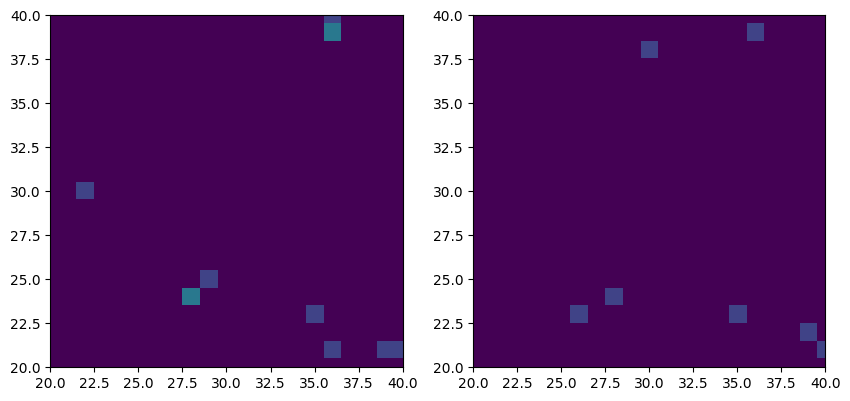

In [20]:
# pl.figure()
# pl.imshow(Nhalos[64,...])
# make it a two panel figure:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.imshow(Nhalos[64,...])
pl.xlim(20,40)
pl.ylim(20,40)

pl.subplot(122)
pl.imshow(Nhalos_truth_recomb[64,...])
pl.xlim(20,40)
pl.ylim(20,40)
pl.show()




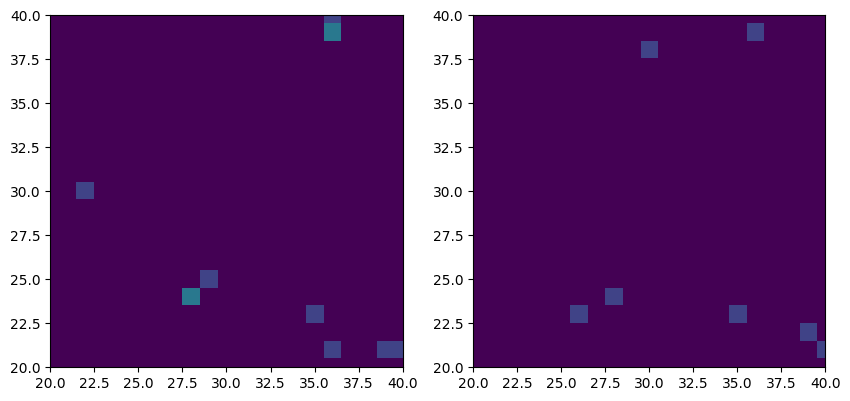

In [21]:
# pl.figure()
# pl.imshow(Nhalos[64,...])
# make it a two panel figure:
pl.figure(figsize=(10, 5))
pl.subplot(121)
pl.imshow(Nhalos[64,...])
pl.xlim(20,40)
pl.ylim(20,40)

pl.subplot(122)
pl.imshow(Nhalos_truth_recomb[64,...])
pl.xlim(20,40)
pl.ylim(20,40)
pl.show()




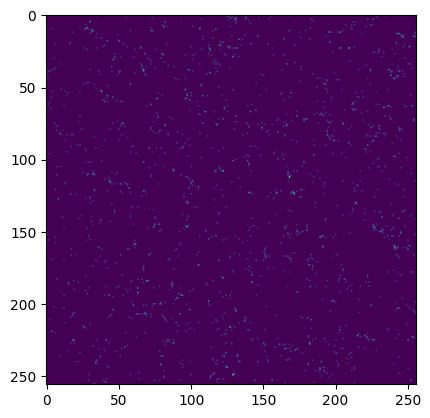

In [22]:
pl.figure()
pl.imshow(df_Nh_truth_comb[64,...])
# Nhalos.shape

In [64]:
# # Nhalos_truth_tensor_jd.shape
# if is_HR:
#     fname = sdir + '/' + str(isim) + '/halos_HR_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# else:
#     fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
# np.sum(df_Nh_truth_comb), np.sum(Nhalos)
# np.amin(lgMass_truth[lgMass_truth > 0]), np.amin(lgMass_mock[lgMass_mock > 0])
# np.amax(lgMass_truth[lgMass_truth > 0]), np.amax(lgMass_mock[lgMass_mock > 0])

len(pos_h_mock), len(pos_h_truth)



(530036, 524062)

In [65]:
# fname
len(pos_h_truth)/len(pos_h_mock)


0.9887290674595688

In [15]:
import matplotlib.pyplot as pl
import matplotlib
%matplotlib inline




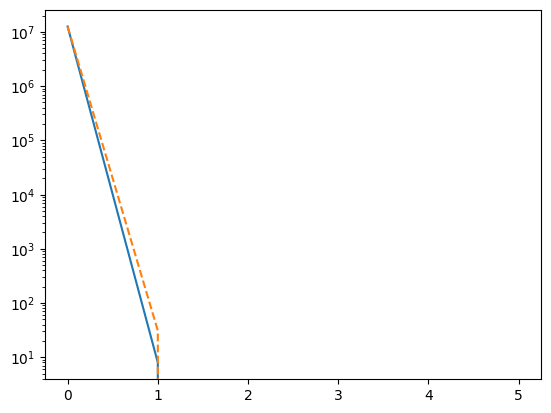

In [23]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_low_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_low_Nhalo'], ls='--')
pl.yscale('log')




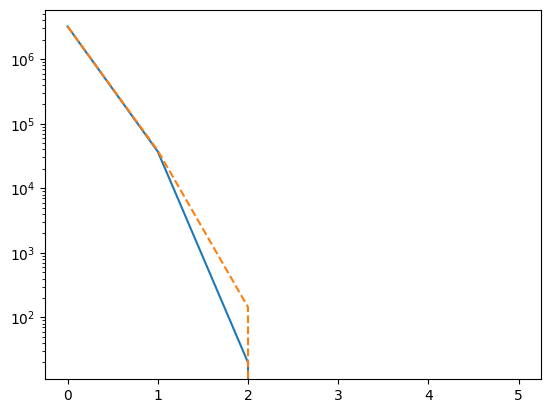

In [24]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_mid_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_mid_Nhalo'], ls='--')
pl.yscale('log')




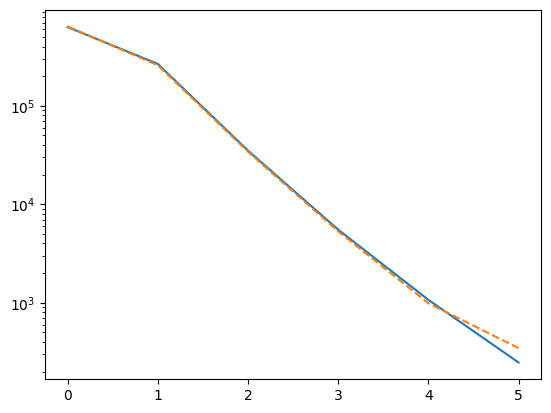

In [25]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_high_Nhalo'])
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo'], ls='--')
pl.yscale('log')




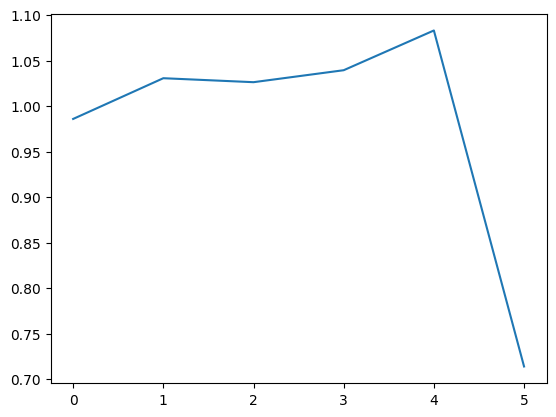

In [26]:
pl.figure()
pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_truth_high_Nhalo']/ saved_all_jsim['hist_samp_high_Nhalo'])
# pl.plot(saved_all_jsim['Nhalo_bin_cents'], saved_all_jsim['hist_samp_high_Nhalo'], ls='--')
# pl.yscale('log')




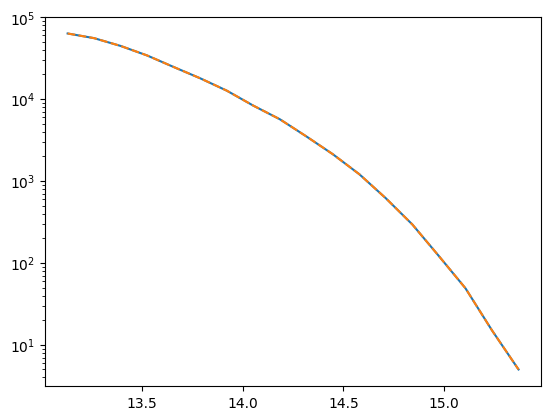

In [36]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_high_Mhalo'][0,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_high_Mhalo'][0,:], ls='--')
pl.yscale('log')




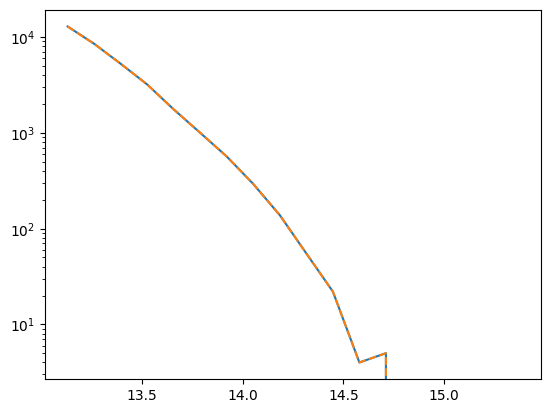

In [37]:
pl.figure()
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_truth_all_Mhalo'][1,:])
pl.plot(saved_all_jsim['Mhalo_bin_cents'], saved_all_jsim['hist_samp_all_Mhalo'][1,:], ls='--')
pl.yscale('log')




In [31]:
saved_all_jsim['Pk_Bk'].keys()


dict_keys([])

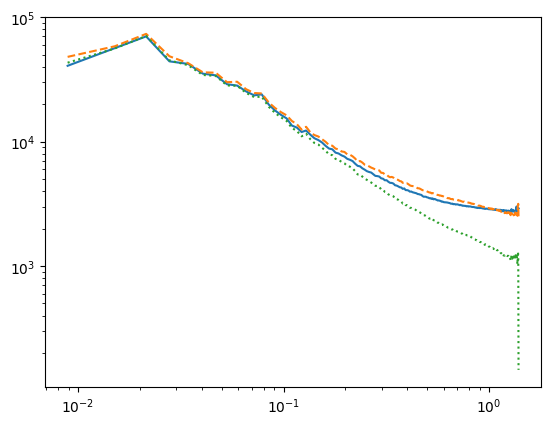

In [29]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
pl.yscale('log')
pl.xscale('log')




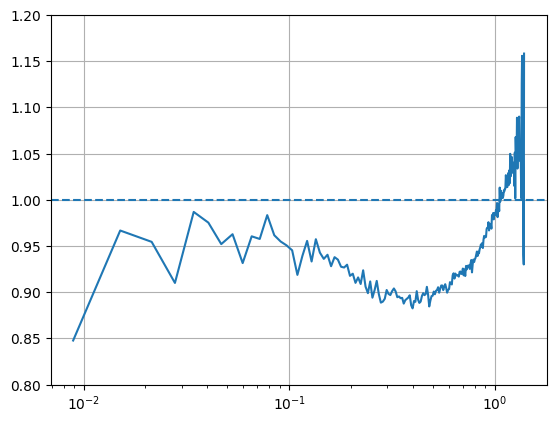

In [30]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth']/saved_all_jsim['Pk_Bk'][0]['Pk_mock'])
# pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][1]['Pk_truth']/saved_all_jsim['Pk_Bk'][1]['Pk_mock'])
# pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][3]['Pk_truth']/saved_all_jsim['Pk_Bk'][3]['Pk_mock'])
# pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], , ls='--')
# pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
# pl.yscale('log')
pl.axhline(1.0, ls='--')
pl.ylim(0.8,1.2)
pl.xscale('log')
pl.grid()




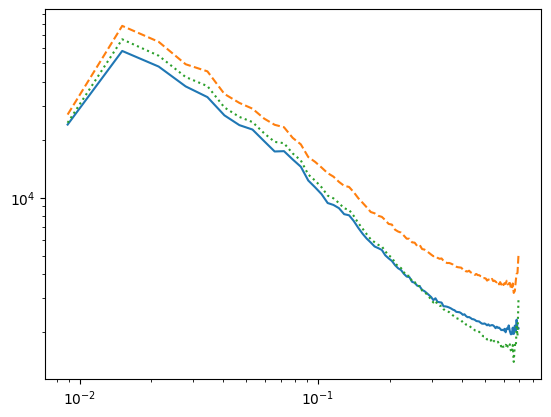

In [63]:
pl.figure()
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_truth'])
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mock'], ls='--')
pl.plot(saved_all_jsim['Pk_Bk'][0]['k_Pk'], saved_all_jsim['Pk_Bk'][0]['Pk_mockxtruth'], ls=':')
pl.yscale('log')
pl.xscale('log')



In [15]:
sdir='/mnt/home/spandey/ceph/Quijote/data_NGP_self'
# load the halo data
fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_subvol_res_' + str(ns_h) + '_z=0.pk'
df_h_subvol = pk.load(open(fname, 'rb'))
# This has information on the halo mass for all the halos in the voxel
df_Mh_all_truth = df_h_subvol['M_halos']
df_Mh_all_truth = np.flip(np.sort(df_Mh_all_truth, axis=-1), axis=-1)
# This has information on the number of halos in the voxel
df_Nh_truth = df_h_subvol['N_halos']

fname = sdir + '/' + str(isim) + '/halos_' + str(mass_type) + '_lgMmincut_' + lgMmincutstr + '_full_res_' + str(ns_h) + '_z=0.pk'
df_h_full = pk.load(open(fname, 'rb'))
df_Mh_all_truth_comb, df_Nh_truth_comb = df_h_full['M_halos_combined'], df_h_full['N_halos_combined']



In [16]:
df_Mh_all_truth_comb.shape

(128, 128, 128, 4)

In [17]:
df_Mh_all_truth.shape


(512, 16, 16, 16, 4)

In [14]:
fname


'/mnt/home/spandey/ceph/Quijote/data_NGP_self/1/halos_fof_lgMmincut_5e13_full_res_128_z=0.pk'